In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings('ignore')


1. RateConst Reader


In [2]:
def getAllRateInfo(file):   
    res=pd.DataFrame()
    try:
        temp=pd.read_csv(file)
        temp=temp.dropna()
        temp['Protein']=file.split('\\')[-1].replace('.RateConst.csv','')
        res=pd.concat([res,temp])
    except Exception as exp:
        return res
    
    return res
def getAllRate(data_path):
    results = Parallel(n_jobs=-1)(delayed(getAllRateInfo)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.RateConst.csv' in x  ]) 
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

2. Quant File Reader

In [3]:
def read_n_merge(skip,file):
    file_data=pd.read_csv(file,skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.split('\\')[-1].replace('.Quant.csv','') 
        return [isparsed,file_data]
    else:
        return [isparsed,None]
def get_df_all_quant_files(file):
    res=read_n_merge(1,file)
    all_data=None
    if res[0]: all_data=res[1]
    else: all_data=read_n_merge(3,file)[1]
    return all_data

def getquantfile(data_path):
    results = Parallel(n_jobs=-1)(delayed(get_df_all_quant_files)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.Quant.csv' in x  ])
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

3. Data source & path

In [4]:
organ="liver"
# organ="heart"
# organ="muscle"
data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
# data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
# data_path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


data_quant=getquantfile(data_path)
data_rate=getAllRate(data_path)
data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]

4. merge quant and rate files

In [5]:
merged=pd.merge(data_quant,
                data_rate,
                left_on=['Protein','Peptide','Charge'],
                right_on=['Protein','Peptides','Charge'])
merged=merged.reset_index(drop=True)
merged.shape

(18510, 219)

5. parameters

In [6]:
pw,ph=0.046,1.5574E-4
rsquared= 0.99
maxrate=math.log(2)
exp_time=[0 ,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]

6. filter data

In [7]:
merged=merged[(merged.Rsquared.astype('float')>=rsquared) &
              (merged.RateConstants< math.log(2))]
merged=merged.reset_index(drop=True)
merged.shape

(929, 219)

7. Helper functions

In [69]:
def get_I0_t(I0_0,I0_asymp,k,t):
    return I0_asymp + (I0_0-I0_asymp)*math.exp(-k*t)

def get_I0_asmyp(I0_0,neh):
    return I0_0*( (1 - pw/(1-ph))**neh )

def get_I0_exp(index,suffix):
    _sum=float(float(merged.loc[index,f'I0{suffix}'])+float(merged.loc[index,f'I1{suffix}'])+float(merged.loc[index,f'I2{suffix}'])+float(merged.loc[index,f'I3{suffix}'])+
                        float(merged.loc[index,f'I4{suffix}'])+float(merged.loc[index,f'I5{suffix}']))
    if _sum==0: return None
    else: return float(merged.loc[index,f'I0{suffix}'])/_sum

def getNewKestimate(M0_0,I0_0_exp,I0_asymp,t,I0_t_exp,numberofTerms): 
        
    base=(I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)    
    new_kt= sum([ (base**i)/i for i in range(1,numberofTerms+1)])     
    new_k=new_kt/t    
    return new_k


def getNewKestimateByIndex(time,numberofterms,index):
        
        time_index=exp_time.index(time)
        suffix=f".{time_index}"  
        print('time',time,time_index)
                                              
        if merged.loc[index,f'I0{suffix}'] == ' ' or merged.loc[index,f'I0'] == ' ': 
            return None            
        
        I0_0_exp= get_I0_exp(index,"")
        I0_t_exp=get_I0_exp(index,suffix)
        
        if I0_0_exp == None or I0_t_exp ==None or  I0_t_exp >  I0_0_exp: 
            return None

        M0_0=float(merged.loc[index,f'M0'])/100
        k=float(merged.loc[index,f'RateConstants'])
        I0_asymp=M0_0*( (1 - pw/(1-ph))**merged.loc[index,f'Exchangeable Hydrogens'] ) 
        i0_t_theo= I0_asymp + (M0_0-I0_asymp)*math.exp(-k*time)        

        return[merged.loc[index,f'Exchangeable Hydrogens'],
                    M0_0,I0_0_exp,
                    I0_asymp,
                    I0_t_exp,i0_t_theo,k] +[getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms)]
        
def computeAllNewRates(_time,_numberOfTerms):
    res = Parallel(n_jobs=-1)(delayed(getNewKestimateByIndex)(_time,_numberOfTerms,index) for index in range(merged.shape[0]))
    res=pd.DataFrame([r for r in res if r!=None])
    res.columns=["NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','new_k']
    return res

def plot_hitmap(x,y):
          
    plt.rc('font',size=14)
    plt.figure(figsize=(7,6))
    plt.set_cmap('jet')  
    
    x=np.array(x)
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    r=np.corrcoef(x,y)
    
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.8)  
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,label=f"n={len(list(x))}\nr={int(1000*r[0][1])/1000}")      
    cbar = plt.colorbar(cb)
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")    
    plt.legend()  
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlim([0,min( max(x),math.log(2) )])
    plt.ylim([0,min( max(x),math.log(2) )])

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.show()
    
def plotRateRDDensity(res):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_k= (res.d2ome_k - res.new_k)/res.d2ome_k
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('m')
    ax.lines[0].set_alpha(0.75) 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    plt.show()
    
def plotI0_expRDDensity(res):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6))
    rd_k= (res.i0_t_theo	 - res.i0_t_exp)/res.i0_t_theo
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('m')
    ax.lines[0].set_alpha(0.75) 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$I0(t)_{theo} - I0(t)_{exp} $')
    plt.legend()
    plt.show()
    
    
    

8. Prepare all new k values

In [70]:
# _res=computeAllNewRates(1,1)

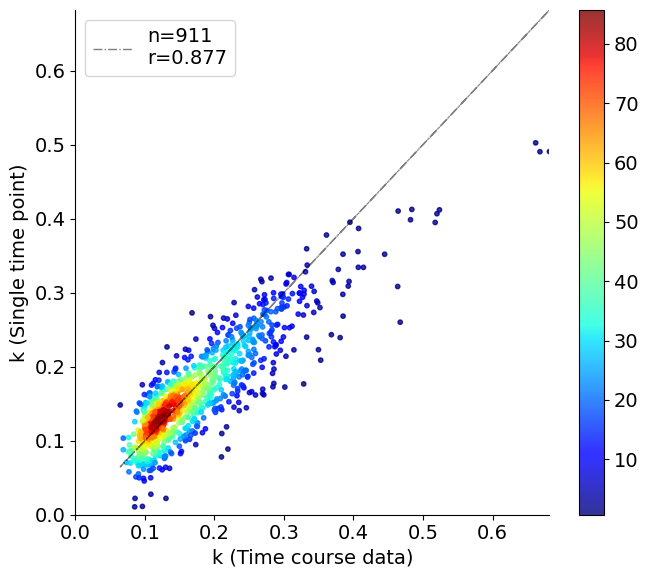

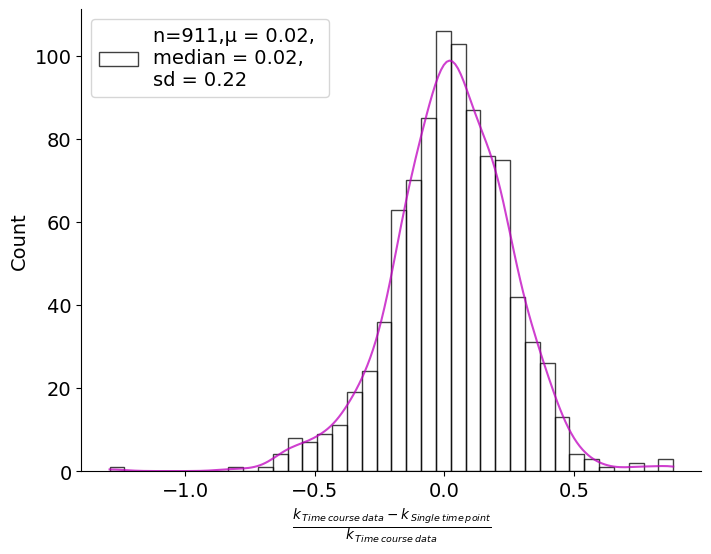

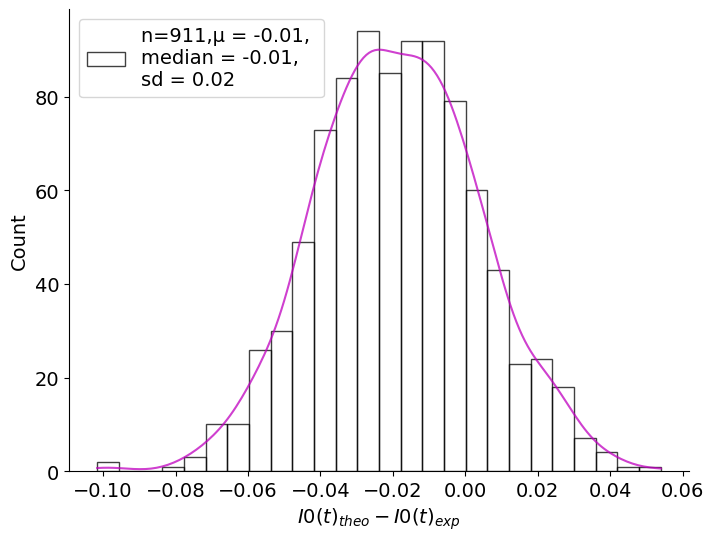

In [71]:
plot_hitmap(_res.d2ome_k,_res.new_k)
plotRateRDDensity(_res)
plotI0_expRDDensity(_res)

In [29]:
  
def templot(res,path,title):  
    res=res.reset_index(drop=True)  
    plt.rc('font',size=14)
    plt.figure(figsize=(6,6))
    plt.set_cmap('jet')
    x=np.array(res.d2ome_k)
    y=np.array(res.new_k)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.2)
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.15,)   
    
    
    
    
    #===========================================================
    rd_k = (res.d2ome_k-res.new_k)/res.d2ome_k
    # rd_i0= ((res.I0_0_exp-res.i0_t_exp) - (res.I0_0_exp-res.i0_t_theo)) / (res.I0_0_exp-res.i0_t_theo)
    # rd_i0= (res.i0_t_theo -res.i0_t_exp)/res.i0_t_theo
    rd_i0= (res.i0_t_theo -res.i0_t_exp)
    #==========================================================
    
    # index=[i for i,val in enumerate(z) if val > (max(z)-max(z)*0.2) ] 
    index=[i for i,val in enumerate(rd_k) if abs(rd_k[i])<0.1 ] 
    
    plt.scatter(x[index],y[index],c='k',s=10,alpha=0.75,label=f"n={len(index)}")
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")        
    # plt.savefig(f"{path}/{title}.jpeg",dpi=900)
    plt.show()
    
    
    #===========================================================
    rd_k = (res.d2ome_k-res.new_k)/res.d2ome_k
    # rd_i0= ((res.I0_0_exp-res.i0_t_exp) - (res.I0_0_exp-res.i0_t_theo)) / (res.I0_0_exp-res.i0_t_theo)
    # rd_i0= (res.i0_t_theo -res.i0_t_exp)/res.i0_t_theo
    rd_i0= (res.i0_t_theo -res.i0_t_exp)
    
    rd_k2 = [val for i,val in enumerate(list((res.d2ome_k-res.new_k)/res.d2ome_k)) if i in index ]
    # rd_i02=  [val for i,val in enumerate(list(((res.I0_0_exp-res.i0_t_exp) - (res.I0_0_exp-res.i0_t_theo)) / (res.I0_0_exp-res.i0_t_theo))) if i in index ]
    # rd_i02=  [val for i,val in enumerate(list( (res.i0_t_theo-res.i0_t_exp)/res.i0_t_theo ) ) if i in index ]
    rd_i02=  [val for i,val in enumerate(list( (res.i0_t_theo-res.i0_t_exp)) ) if i in index ]
         
    # #================================================
    plt.rc('font',size=14)
    plt.figure(figsize=(9,7))
    ax2=sns.histplot(rd_k2, kde=False, #bins=50,
                label=f"n={len(rd_k2)},μ = {int(100*np.mean(rd_k2))/100}, \nmedian = {int(100*np.median(rd_k2))/100}, \nsd = {int(100*np.std(rd_k2))/100}",
                color='red',alpha=0.1,edgecolor=('red',0.15))
    # ax2.lines[0].set_color('red')
    
    # plt.xlabel(r'$\frac{ k_{d2ome} - k_{approx.}}{k_{d2ome}}$')
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    
    # plt.xlim([max(-10,min(rd_k)), min(10,max(rd_k))])
    
    # plt.savefig(f"{path}/{title}_density.jpeg",dpi=900)
    plt.show()
    
    # ## ===================================================
    plt.rc('font',size=14)
    plt.figure(figsize=(9,7))
    ax2=sns.histplot(rd_i02, kde=False, #bins=50,
                label=f"n={len(rd_i02)},μ = {int(100*np.mean(rd_i02))/100}, \nmedian = {int(100*np.median(rd_i02))/100}, \nsd = {int(100*np.std(rd_i02))/100}",
                color='red',alpha=0.1,edgecolor=('red',0.15) )
    # ax.lines[0].set_color('black')
    
    # plt.xlabel(r'$\frac{ k_{i0} - k_{ii.}}{k_{i0}}$')
    # plt.xlabel(r'$\frac{ (I0(0)_{exp} - I0(t)_{exp}) - (I0(0)_{theo} - I0(t)_{theo}) }   { (I0(0)_{theo} - I0(t)_{theo}) }  $')
    # plt.xlabel(r'$\frac{  I0(t)_{theo} - I0(t)_{exp} }   { I0(t)_{theo} }  $')
    plt.xlabel(r'$I0(t)_{theo} - I0(t)_{exp} $')
    plt.legend()
    
    # plt.xlim([max(-10,min(rd_i02)), min(10,min(rd_i02))])
    # plt.savefig(f"{path}/{title}_I0_density.jpeg",dpi=900)
    plt.show()
    

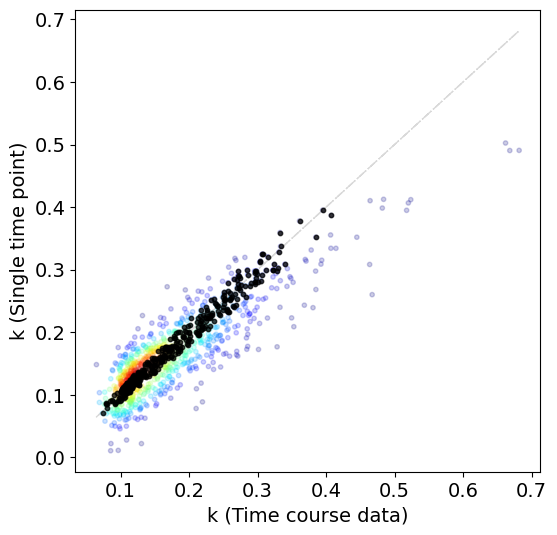

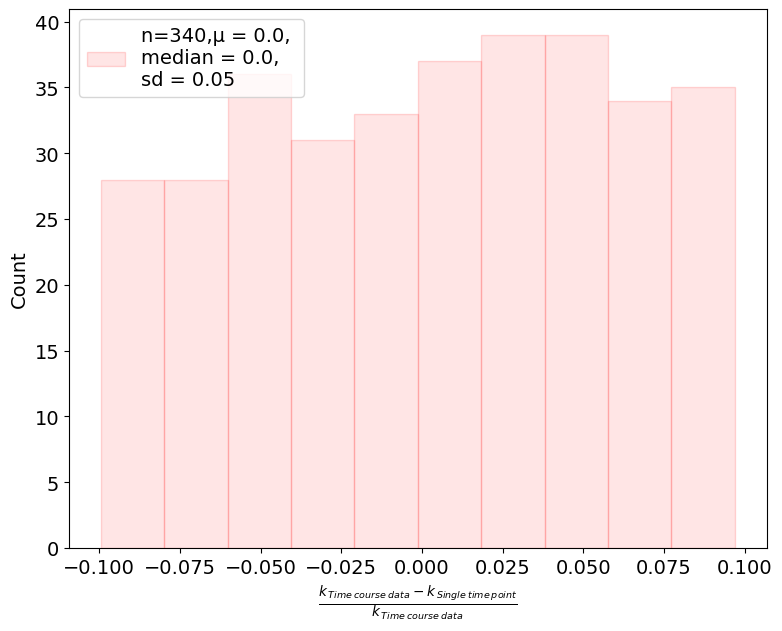

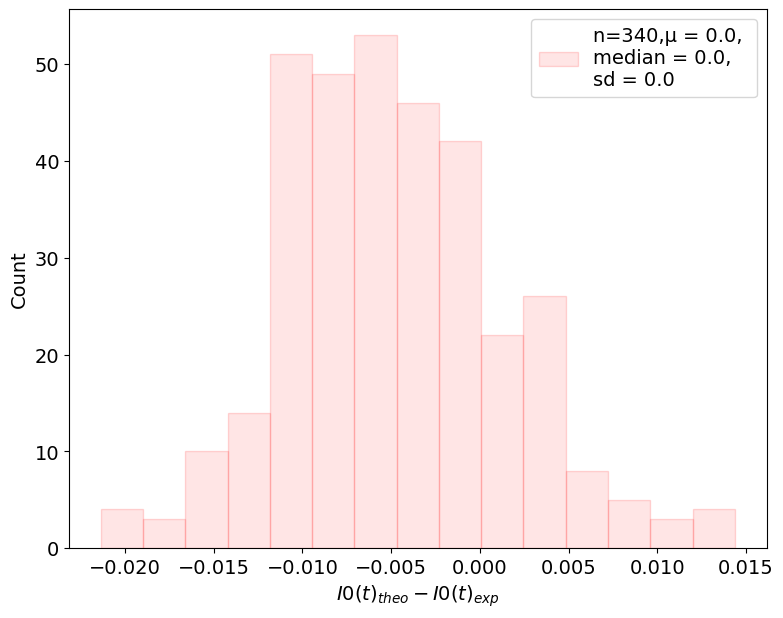

In [30]:
templot(_res,"","")

In [6]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

def plot_hitmap(x,y,nehs,title,path="",xlabel="",ylabel=""):      
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    x=np.array(x)
    y=np.array(y)
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    r=np.corrcoef(x,y)
    
    plt.set_cmap('jet')  
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.8)  
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,label=f"n={len(list(x))}\nr={int(1000*r[0][1])/1000}")      
    cbar = plt.colorbar(cb)
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlim([0,min( max(x),math.log(2) )])
    plt.ylim([0,min( max(x),math.log(2) )])

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    
    # plt.savefig(f"Figures/{organ}/{title}.jpeg",dpi=900)
    plt.savefig(f"{path}/{title}.jpeg",dpi=900)
    plt.show()
    
    #==================================
    
def plotRateRelativeDiff(res,path,title):    
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    plt.rc('font',size=14)
    #====relative difference plot
    rd=(res.d2ome_k-res.new_k)/res.d2ome_k
    ax=sns.histplot(rd, kde=True, #bins=50,
                label=f"n={len(rd)},μ = {int(100*np.mean(rd))/100}, \nmedian = {int(100*np.median(rd))/100}, \nsd = {int(100*np.std(rd))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.15),kde_kws={"bw_adjust":0.85} )
    ax.lines[0].set_color('black')
    
    plt.xlabel(r'$\frac{ k_{d2ome} - k_{approx.}}{k_{d2ome}}$')    
    plt.savefig(f"{path}/{title}_density.jpeg",dpi=900)
    plt.legend()
    plt.show()
    
# ["NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','new_k'] 
def plotdif_I0_dif_vs_rate_dif(res): 
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    x=(res.d2ome_k-res.new_k)/res.d2ome_k
    y=abs(((res.I0_0_exp-res.i0_t_exp) - (res.M0-res.i0_t_theo)) / (res.M0-res.i0_t_theo))
    plt.set_cmap('magma')    
    plt.scatter(x,y,c=abs(x))
    plt.show()
    
def templot(res,path,title):    
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    
    x=np.array(res.d2ome_k)
    y=np.array(res.new_k)
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    index=[i for i,val in enumerate(z) if val > (max(z)-max(z)*0.2) ]
    cb=plt.scatter(x, y, c=z, s=10,alpha=0.2)
    plt.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,)
    
    plt.scatter(x[index],y[index],c='r',s=10,alpha=0.9)
    plt.ylabel("k (Single time point)")
    plt.xlabel("k (Time course data)")
        
    plt.savefig(f"{path}/{title}.jpeg",dpi=900)
    plt.show()
    
    
    rd_k = (res.d2ome_k-res.new_k)/res.d2ome_k
    rd_i0= ((res.I0_0_exp-res.i0_t_exp) - (res.M0-res.i0_t_theo)) / (res.M0-res.i0_t_theo)
    
    rd_k2 = [val for i,val in enumerate(list((res.d2ome_k-res.new_k)/res.d2ome_k)) if i in index ]
    rd_i02=  [val for i,val in enumerate(list(((res.I0_0_exp-res.i0_t_exp) - (res.M0-res.i0_t_theo)) / (res.M0-res.i0_t_theo))) if i in index ]
         
    #================================================    
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.15),kde_kws={"bw_adjust":0.85} )
    ax.lines[0].set_color('black')
    
    plt.xlabel(r'$\frac{ k_{d2ome} - k_{approx.}}{k_{d2ome}}$')
    # plt.show()
                 
    #================================================
    ax2=sns.histplot(rd_k2, kde=True, #bins=50,
                label=f"n={len(rd_k2)},μ = {int(100*np.mean(rd_k2))/100}, \nmedian = {int(100*np.median(rd_k2))/100}, \nsd = {int(100*np.std(rd_k2))/100}",
                color='red',alpha=0.1,edgecolor=('red',0.15),kde_kws={"bw_adjust":1.5} )
    # ax2.lines[0].set_color('red')
    
    plt.xlabel(r'$\frac{ k_{d2ome} - k_{approx.}}{k_{d2ome}}$')
    plt.legend()
    
    # plt.xlim([max(-10,min(rd_k)), min(10,max(rd_k))])
    
    plt.savefig(f"{path}/{title}_density.jpeg",dpi=900)
    plt.show()
    
    # #================================================    
    plt.rc('font',size=14)
    plt.figure(figsize=(7,7))
    ax=sns.histplot(rd_i0, kde=True, #bins=50,
                label=f"n={len(rd_i0)},μ = {int(100*np.mean(rd_i0))/100}, \nmedian = {int(100*np.median(rd_i0))/100}, \nsd = {int(100*np.std(rd_i0))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.15),kde_kws={"bw_adjust":0.85} )
    ax.lines[0].set_color('black')
    
    plt.xlabel(r'$\frac{ (I0(0)_{exp} - I0(t)_{exp}) - (I0(0)_{theo} - I0(t)_{theo}) }   { (I0(0)_{theo} - I0(t)_{theo}) }  $')
    # plt.show()
    
    ## ===================================================
    ax2=sns.histplot(rd_i02, kde=True, #bins=50,
                label=f"n={len(rd_i02)},μ = {int(100*np.mean(rd_i02))/100}, \nmedian = {int(100*np.median(rd_i02))/100}, \nsd = {int(100*np.std(rd_i02))/100}",
                color='red',alpha=0.1,edgecolor=('red',0.15),kde_kws={"bw_adjust":1.5} )
    # ax.lines[0].set_color('black')
    
    # plt.xlabel(r'$\frac{ k_{i0} - k_{ii.}}{k_{i0}}$')
    plt.legend()
    
    # plt.xlim([max(-10,min(rd_i02)), min(10,min(rd_i02))])
    plt.savefig(f"{path}/{title}_I0_density.jpeg",dpi=900)
    plt.show()
    
    ## ===================================================  
    plt.rc('font',size=14)
    plt.figure(figsize=(8,8))
    plt.set_cmap('hot')       
    plt.scatter(rd_k2,rd_i02,c=[abs(i) for i in rd_k2],alpha=0.4)    
    plt.ylabel(r'$\frac{ (I0(0)_{exp} - I0(t)_{exp}) - (I0(0)_{theo} - I0(t)_{theo}) }   { (I0(0)_{theo} - I0(t)_{theo}) }  $')
    plt.xlabel(r'$\frac{ k_{d2ome} - k_{approx.}}{k_{d2ome}}$')
    
    plt.savefig(f"{path}/{title}_I0_k_dif.jpeg",dpi=600)
    plt.show()
    

In [22]:
organ="liver"
# organ="heart"
# organ="muscle"
data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
# data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
# data_path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


data_quant=get_df_all_quant_files(data_path)
data_rate=getAllRateInfo(data_path)
data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]

100%|██████████| 2010/2010 [00:37<00:00, 53.18it/s]


In [23]:
pw,ph=0.046,1.5574E-4
rsquared= 0.99
merged=pd.merge(data_quant,
                data_rate[ (data_rate.Rsquared.astype('float')>=rsquared) & (data_rate.RateConstants< math.log(2))],
                left_on=['Protein','Peptide','Charge'],
                right_on=['Protein','Peptides','Charge'])
merged=merged.reset_index(drop=True)

# merged.to_csv(f"merged_{organ}.csv",index=False)

In [24]:
def get_I0_t(I0_0,I0_asymp,k,t):
    return I0_asymp + (I0_0-I0_asymp)*math.exp(-k*t)

def get_I0_asmyp(I0_0,neh):
    return I0_0*( (1 - pw/(1-ph))**neh )

def get_I0_exp(index,suffix):
    _sum=float(float(merged.loc[index,f'I0{suffix}'])+float(merged.loc[index,f'I1{suffix}'])+float(merged.loc[index,f'I2{suffix}'])+float(merged.loc[index,f'I3{suffix}'])+
                        float(merged.loc[index,f'I4{suffix}'])+float(merged.loc[index,f'I5{suffix}']))
    if _sum==0: return None
    else: return float(merged.loc[index,f'I0{suffix}'])/_sum

def getNewKestimate(M0_0,I0_0_exp,I0_asymp,t,I0_t_exp,numberofTerms): 
        
    base=(I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)    
    new_kt= sum([ (base**i)/i for i in range(1,numberofTerms+1)])     
    new_k=new_kt/t    
    return new_k
  


In [25]:
exp_time=[0 ,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]

In [26]:
plt.figure(figsize=(7,5))
plt.rc('font',size=14)
def getnewEstimation(time_index,numberofterms,figname):
        
        time=exp_time[time_index]
        print('time',time,time_index)

        res=[] 
        for index in range(merged.shape[0]):
                                
                suffix=f".{time_index}"                
                if merged.loc[index,f'I0{suffix}'] == ' ' or merged.loc[index,f'I0'] == ' ': continue
                
                I0_0_exp= get_I0_exp(index,"")
                I0_t_exp=get_I0_exp(index,suffix)
                
                if I0_0_exp == None or I0_t_exp ==None or  I0_t_exp >  I0_0_exp: continue

                M0_0=float(merged.loc[index,f'M0'])/100
                k=float(merged.loc[index,f'RateConstants'])
                I0_asymp=M0_0*( (1 - pw/(1-ph))**merged.loc[index,f'Exchangeable Hydrogens'] ) 
                i0_t_theo= I0_asymp + (M0_0-I0_asymp)*math.exp(-k*time)
                

                temp_res=[merged.loc[index,f'Exchangeable Hydrogens'],
                          M0_0,I0_0_exp,
                          I0_asymp,
                          I0_t_exp,i0_t_theo,k] +[getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms)]
                res.append(temp_res)
        res=pd.DataFrame(res)
        res.columns=["NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','new_k']
        
        _path=f"Figures/{organ}/Day_{time}/r2_{rsquared}/numberofterms_{numberofterms}/"
        _path2=f"Figures/{organ}/Day_{time}/r2_{rsquared}/numberofterms_{numberofterms}/subgroup/"
        if not os.path.exists(_path): os.makedirs(_path)
        if not os.path.exists(_path2): os.makedirs(_path2)
        
        _title=f"{organ}_day_{time}_numberofterms_{numberofterms}"
        plot_hitmap(res.d2ome_k,res.new_k,res.NEH,_title,_path,"k (d2ome)","k'")
        # plotRateRelativeDiff(res,_path,_title)
        # ##plotdif_I0_dif_vs_rate_dif(res)
        # templot(res,_path2,_title)
        

        
        
                

<Figure size 700x500 with 0 Axes>

time 1 1


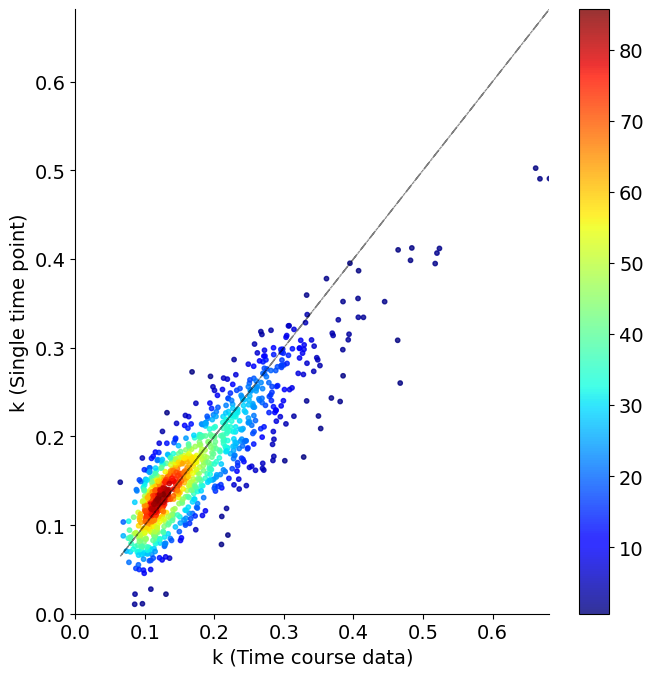

time 1 1


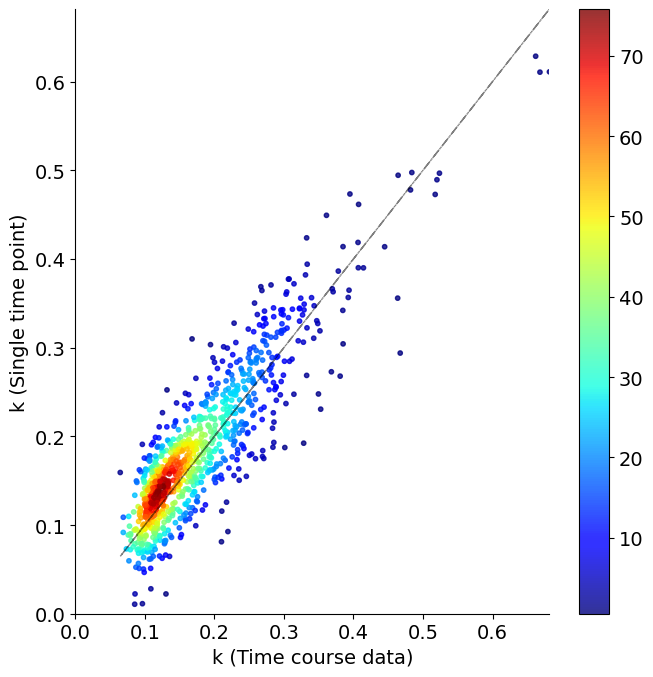

time 2 2


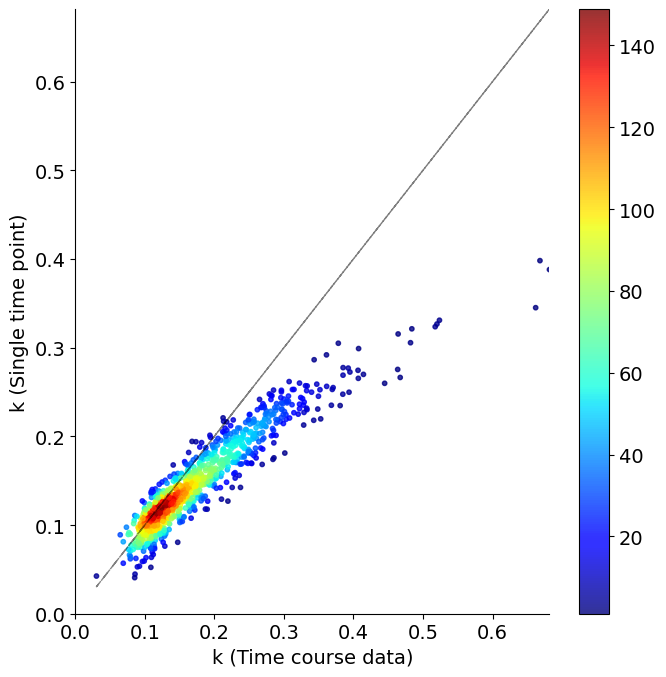

time 2 2


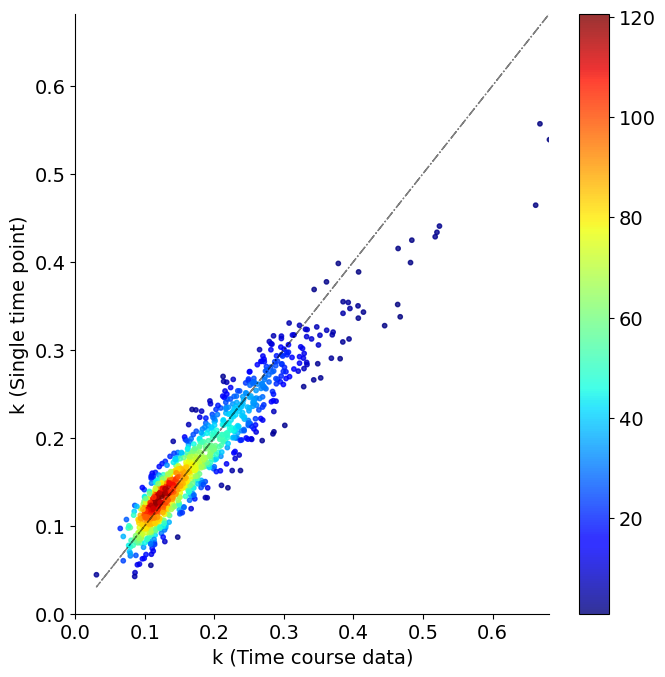

time 3 3


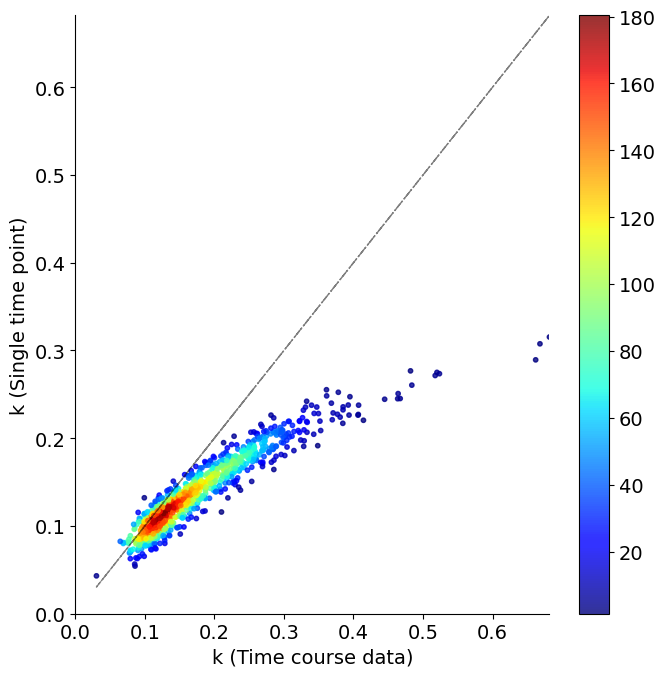

time 3 3


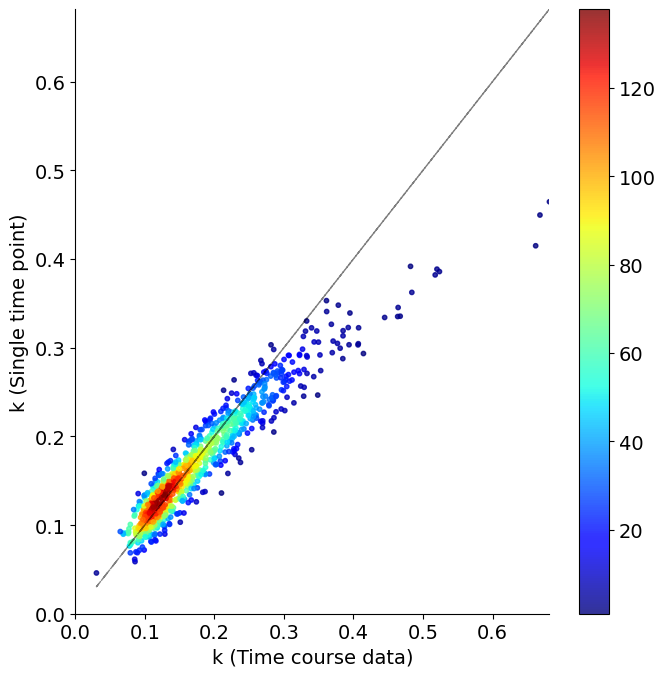

time 6 4


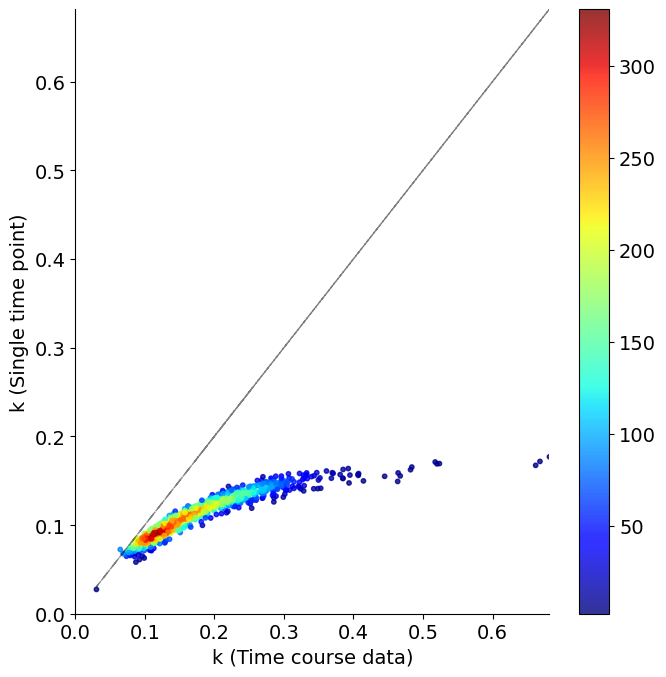

time 6 4


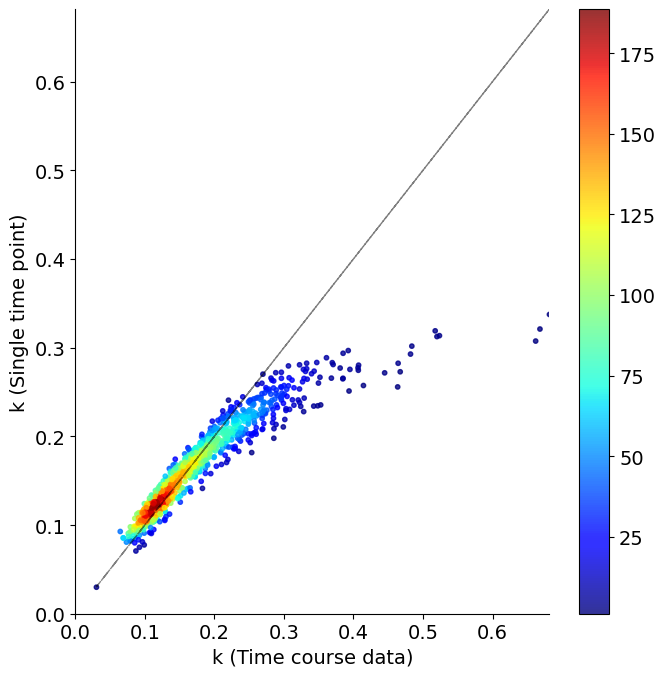

In [27]:
savefigs=False
getnewEstimation(exp_time.index(1),1,"")
getnewEstimation(exp_time.index(1),2,"")

getnewEstimation(exp_time.index(2),1,"")
getnewEstimation(exp_time.index(2),2,"")

getnewEstimation(exp_time.index(3),1,"")
getnewEstimation(exp_time.index(3),2,"")


getnewEstimation(exp_time.index(6),1,"")
getnewEstimation(exp_time.index(6),3,"")